In [8]:
%load_ext autoreload
%autoreload 2

import torch

from text3d2video.pipelines.pipeline_utils import load_pipeline
from text3d2video.pipelines.method import TexturingPipeline

torch.set_grad_enabled(False)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [9]:
pipe = load_pipeline(TexturingPipeline)

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

In [56]:
from text3d2video.artifacts.anim_artifact import AnimationArtifact

anim_tag = 'mv_cat_statue:latest'
anim_tag = 'human_mv:latest'

texture_anim = AnimationArtifact.from_wandb_artifact_tag(anim_tag)
cams, meshes = texture_anim.load_frames()
verts_uvs, faces_uvs = texture_anim.uv_data()

In [57]:
from text3d2video.rendering import render_rgb_uv_map
from text3d2video.utilities.ipython_utils import display_vid
from text3d2video.utilities.video_comparison import display_vids
from text3d2video.utilities.video_util import pil_frames_to_clip

prompt = "Deadpool"
uvs = render_rgb_uv_map(meshes, cams, verts_uvs, faces_uvs)
vid = pil_frames_to_clip(uvs)

display_vids([vid], title=prompt)

In [ ]:
from pathlib import Path
from text3d2video.pipelines.method import TexturingConfig
from text3d2video.utilities.logging import H5Logger

texgen_config = TexturingConfig(
    num_inference_steps=10,
    guidance_scale=7.5,
    controlnet_conditioning_scale=1.0,
    uv_res=600,
)

generator = torch.Generator(device="cuda")
generator.manual_seed(1)

logger = H5Logger(Path("texgen_data.h5"))
logger.delete_data()
logger.open_write()
logger.enabled = True

indices = torch.arange(len(cams), device="cuda")

images = pipe(
    prompt,
    meshes[indices],
    cams[indices],
    verts_uvs,
    faces_uvs,
    texgen_config=texgen_config,
    generator=generator,
    logger=logger,
)

logger.close()
logger.open_read()

  0%|          | 0/10 [00:00<?, ?it/s]

texture 

 10%|█         | 1/10 [00:05<00:48,  5.34s/it]

tensor(7.3950, device='cuda:0') text tensor(0.1050, device='cuda:0')
texture 

 20%|██        | 2/10 [00:10<00:43,  5.40s/it]

tensor(7.2259, device='cuda:0') text tensor(0.2741, device='cuda:0')
texture 

 30%|███       | 3/10 [00:16<00:37,  5.40s/it]

tensor(6.8856, device='cuda:0') text tensor(0.6144, device='cuda:0')
texture 

 40%|████      | 4/10 [00:21<00:32,  5.41s/it]

tensor(6.3014, device='cuda:0') text tensor(1.1986, device='cuda:0')
texture 

 50%|█████     | 5/10 [00:27<00:27,  5.42s/it]

tensor(5.4375, device='cuda:0') text tensor(2.0625, device='cuda:0')
texture 

 60%|██████    | 6/10 [00:32<00:21,  5.45s/it]

tensor(4.3284, device='cuda:0') text tensor(3.1716, device='cuda:0')
texture 

 70%|███████   | 7/10 [00:38<00:16,  5.45s/it]

tensor(3.0839, device='cuda:0') text tensor(4.4161, device='cuda:0')
texture 

 80%|████████  | 8/10 [00:43<00:10,  5.46s/it]

tensor(1.8589, device='cuda:0') text tensor(5.6411, device='cuda:0')
texture 

 90%|█████████ | 9/10 [00:48<00:05,  5.46s/it]

tensor(0.8026, device='cuda:0') text tensor(6.6974, device='cuda:0')
texture 

100%|██████████| 10/10 [00:54<00:00,  5.45s/it]

tensor(0.0128, device='cuda:0') text tensor(7.4872, device='cuda:0')


In [ ]:
display_vid(pil_frames_to_clip(images))

: 

501


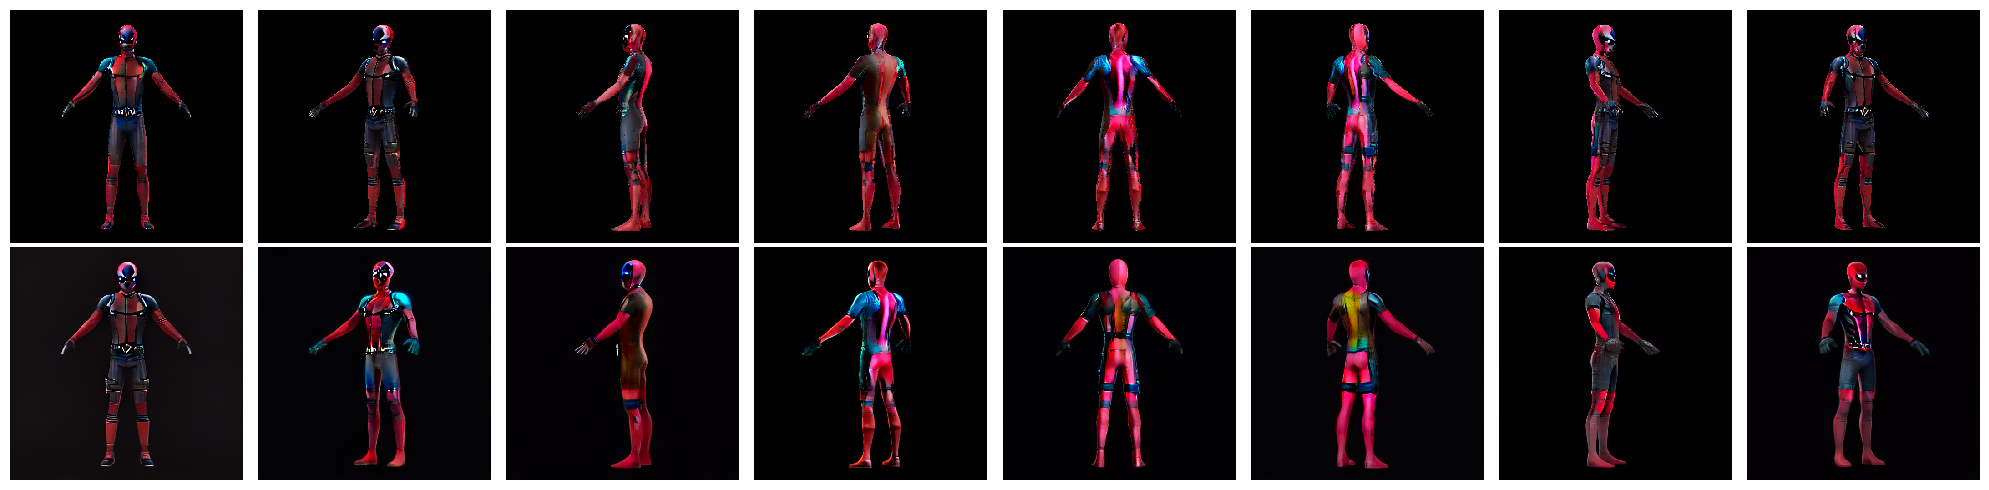

In [66]:
import torchvision.transforms.functional as TF

from text3d2video.util import object_array
from text3d2video.utilities.ipython_utils import display_ims_grid

ts = sorted(logger.key_values("clean_im", "t"), reverse=True)
frame_is = sorted(logger.key_values("clean_im", "frame_i"))

t_vis = ts[4]
print(t_vis)

to_pil = TF.to_pil_image

clean_ims = [
    logger.read("clean_im", t=t_vis, frame_i=f, transform=to_pil) for f in frame_is
]
rendered = [
    logger.read("rendered", t=t_vis, frame_i=f, transform=to_pil) for f in frame_is
]

grid = object_array([rendered, clean_ims])
display_ims_grid(grid)

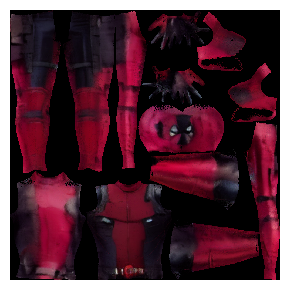

In [61]:
# project to texture
from text3d2video.backprojection import aggregate_views_uv_texture_mean, project_visible_texels_to_camera
from text3d2video.utilities.ipython_utils import display_ims


texture_res = 1000
projections = [
    project_visible_texels_to_camera(
        m, c, verts_uvs, faces_uvs, texture_res, raster_res=2000
    )
    for m, c in zip(meshes, cams)
]
xys = [p.xys for p in projections]
uvs = [p.uvs for p in projections]

texturing_frames_pt = [TF.to_tensor(f) for f in images]
texturing_frames_pt = torch.stack(texturing_frames_pt).cuda()
texture = aggregate_views_uv_texture_mean(texturing_frames_pt, texture_res, xys, uvs)

display_ims([texture.cpu()])

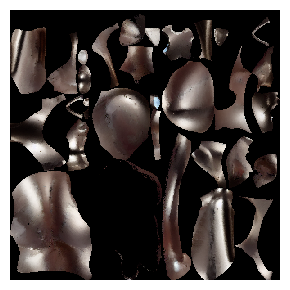

In [52]:
texture = logger.read("clean_tex", t=ts[-1]).cuda()
display_ims([texture.cpu()])

In [53]:
from text3d2video.rendering import render_texture


anim = AnimationArtifact.from_wandb_artifact_tag("mv_cat_statue_20:latest")
anim_cams, anim_meshes = anim.load_frames()
anim_verts_uvs, anim_faces_uvs = anim.uv_data()

renders = render_texture(
    anim_meshes, anim_cams, texture, anim_verts_uvs, anim_faces_uvs, return_pil=True
)

display_vid(pil_frames_to_clip(renders, fps=15))